# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.interpolate import interp1d
from scipy.optimize import minimize
sys.path.append('documents/BNL/jupyter/notebooks/calibrator')
os.environ['LUSEE_DRIVE_DIR']='/home/anze/work/lusee/Drive/'
from algorithms import  Comb, Calibrator
import pickle

In [2]:
# load in luseepy
current_dir = os.getcwd()

# Get the path to BNL/jupyter directory
jupyter_dir = os.path.abspath(os.path.join(current_dir, '../..'))
# Append the jupyter directory to the system path
sys.path.append(jupyter_dir)

import luseepy
from luseepy import lusee

In [3]:
B=lusee.Beam()


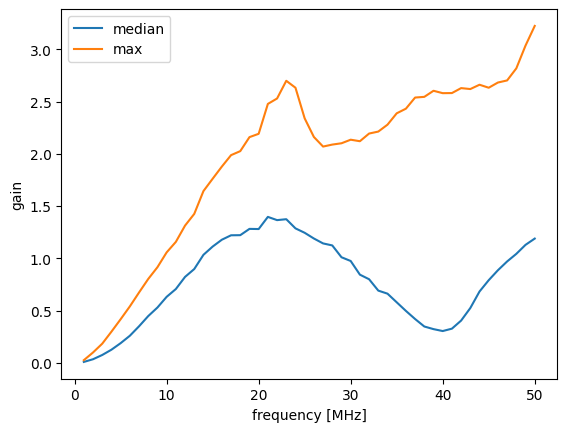

In [9]:
medgain = [np.median(B.gain[i,:,:]) for i in np.arange(len(B.freq))]
maxgain = [np.max(B.gain[i,:,:]) for i in np.arange(len(B.freq))]
plt.plot(B.freq,medgain,label='median')
plt.plot(B.freq,maxgain,label='max')
plt.xlabel('frequency [MHz]')
plt.ylabel('gain')
plt.legend()

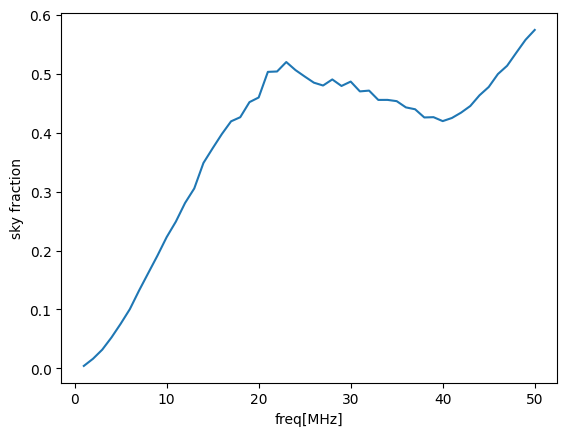

In [10]:

plt.plot(B.freq,B.sky_fraction())
plt.xlabel('freq[MHz]')
plt.ylabel('sky fraction')
sky_fraction = interp1d(B.freq,B.sky_fraction(),kind='linear')




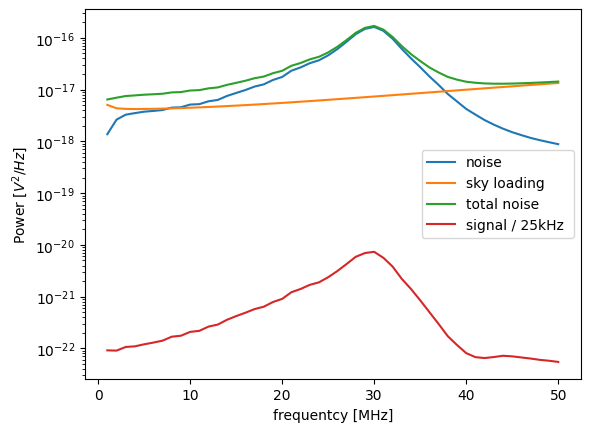

In [16]:
T=lusee.Throughput()

B2T = 3e8**2/(2*1.38e-23*B.freq**2)
Nsky = np.array(T.T2Vsq(B.freq)*lusee.MonoSkyModels.T_NB(B.freq)*sky_fraction(B.freq))
Namp = np.array(T.noise(B.freq))
Bw = 100e3/400 # as per gina
lmb = 3e8/(B.freq*1e6)
X = lmb**2/(4*np.pi)*medgain
kb = 1.38e-23
A = np.array(np.ones(len(B.freq))*1e-22*Bw*X*T.T2Vsq(B.freq)/kb/25e3)
plt.plot(B.freq,Nsky, label='noise')
plt.plot(B.freq,Namp,label='sky loading')
plt.plot(B.freq,Nsky+Namp, label='total noise')
plt.plot(B.freq,A, label = 'signal / 25kHz ')
plt.semilogy()
Ai = interp1d(B.freq,A,kind='linear')
Ni = interp1d(B.freq,Nsky+Namp,kind='linear')
plt.xlabel('frequentcy [MHz]')  
plt.ylabel('Power [$V^2/Hz$]')
plt.legend()



In [17]:
kar = np.arange(181,181+410*2,2)
freq = kar*50e3
print (freq.min(),freq.max(),len(freq))
As = np.sqrt(Ai(freq/1e6)) # amplitude not power
Ns = np.sqrt(Ni(freq/1e6)) # sigma not sigma^2

9050000.0 49950000.0 410


In [18]:
np.save('As.npy',As)
np.save('Ns.npy',Ns)
np.save('kar',kar)

In [19]:
precompensation = np.load('precompensation.npz')['precomp'][90:90+410]
precompensation /= precompensation.sum()
antenna = 1/np.copy(precompensation)
freq=(kar*50e3)/1e6

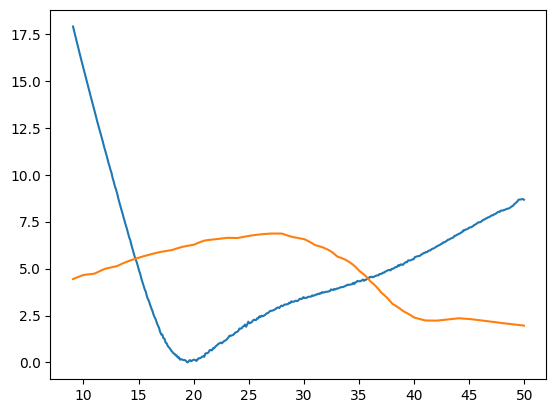

In [20]:
plt.plot(freq,np.log10(precompensation/precompensation.min())*10)
plt.plot(freq,As/Ns*1000)

In [21]:
precompensation_fix = np.copy(precompensation)
precompensation_fix[freq<18]*=0.01
precompensation_fix[(freq>=25)]*=0.01
istart = 270
istep = 8
precompensation_fix[istart+0::istep]*=8
for j in range(1,istep):
    precompensation_fix[istart+j::istep]*=0

precompensation_fix/=precompensation_fix.sum()

precompensation_fix2 = 1/np.copy(precompensation)**2
precompensation_fix2/=precompensation_fix2.sum()


1.0 1.0


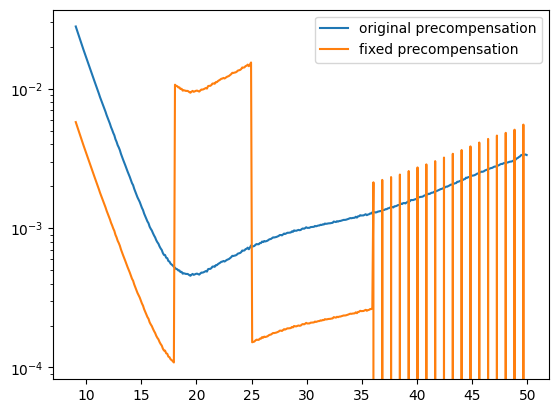

In [27]:
plt.plot(freq,precompensation,label = 'original precompensation')
plt.plot(freq,precompensation_fix, label = 'fixed precompensation')
print ((precompensation).sum(),(precompensation_fix).sum())
plt.semilogy()
plt.legend()

410.0 1512.710024684053


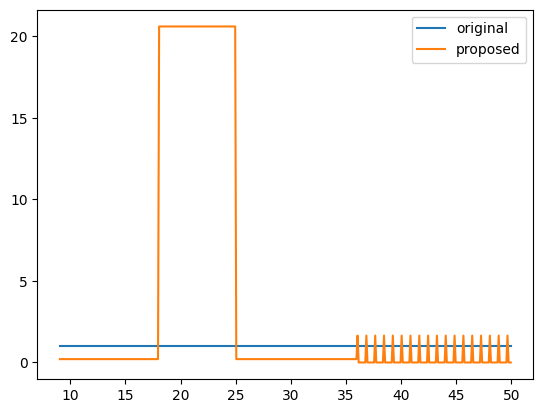

In [29]:
plt.plot(freq,precompensation*antenna, label='original')
plt.plot(freq,precompensation_fix*antenna, label='proposed')
plt.legend()
print ((precompensation*antenna).sum(),(precompensation_fix*antenna).sum())


In [30]:
Asfix = As*np.sqrt(precompensation_fix*antenna)
np.save('Asfix.npy',Asfix)

[]

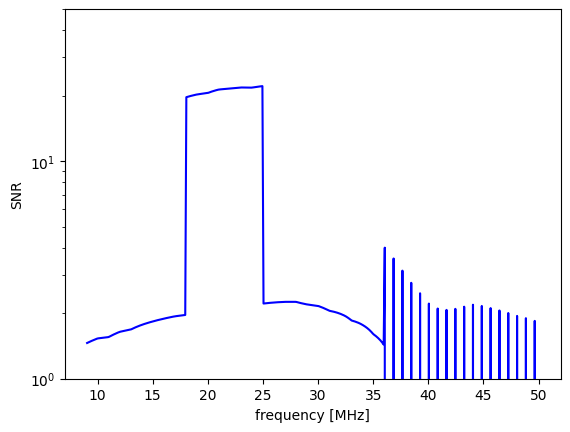

In [46]:
plt.plot(freq,Asfix/Ns*np.sqrt(16*256*128),'b-')
plt.xlabel('frequency [MHz]')
plt.ylabel('SNR')
plt.ylim(1,50)
plt.semilogy()

In [296]:
comb=Comb(kar,response=Asfix, noise=Ns)
C = Calibrator(comb, alpha=-0.3,dalpha_dt=0.0003, add_noise=True, sc=1000, ssig=300, sA=5)
C.analyze_data(alpha_start=+0.3,tmax=2000)
C.cross_correlate()

C2 = Calibrator(comb, alpha=-0.3,dalpha_dt=0.0003, add_noise=True, sc=1000, ssig=300, sA=5, delta_drift_cor_B=4000)
C2.analyze_data(alpha_start=+0.3,tmax=2000)
C2.cross_correlate()

res = C.results
res2 = C2.results

/home/anze/Dropbox/work/lusee/notebooks/calibrator/algorithms.py:180: RuntimeWarning: invalid value encountered in log10
  SNRdB = np.log10(SNR2-420)*10
/home/anze/Dropbox/work/lusee/notebooks/calibrator/algorithms.py:99: RuntimeWarning: invalid value encountered in scalar divide
  ofs = FD/SD


FD mean: -1370.8403505391545 SD mean: -23419782572.908604
1.0053096491487338e-05


/home/anze/Dropbox/work/lusee/notebooks/calibrator/algorithms.py:268: RuntimeWarning: divide by zero encountered in divide
  phased_l = l*np.exp(-1j*phi*self.comb.kcomb)*np.conj(self.comb.code)/self.comb.true_resp/(self.Nintg*self.Nstage3)
/home/anze/Dropbox/work/lusee/notebooks/calibrator/algorithms.py:268: RuntimeWarning: invalid value encountered in divide
  phased_l = l*np.exp(-1j*phi*self.comb.kcomb)*np.conj(self.comb.code)/self.comb.true_resp/(self.Nintg*self.Nstage3)


FD mean: -443.10074301087553 SD mean: -23414095025.12627
1.0053096491487338e-05


In [297]:
#res=pickle.load(open('res2000_2.pickle','rb'))

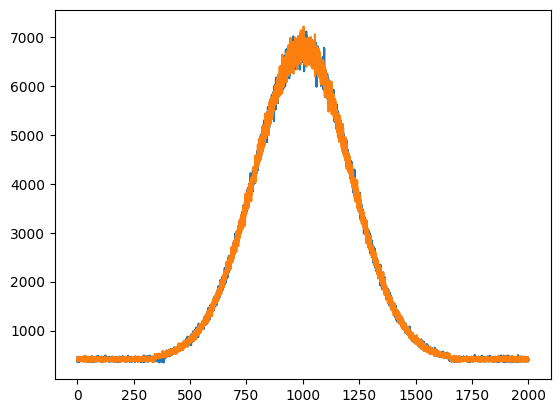

In [298]:
t=res['t']
plt.plot(t,res['SNR2'])
plt.plot(t,res2['SNR2'])

In [299]:
C.count3

0

(250.0, 500.0)

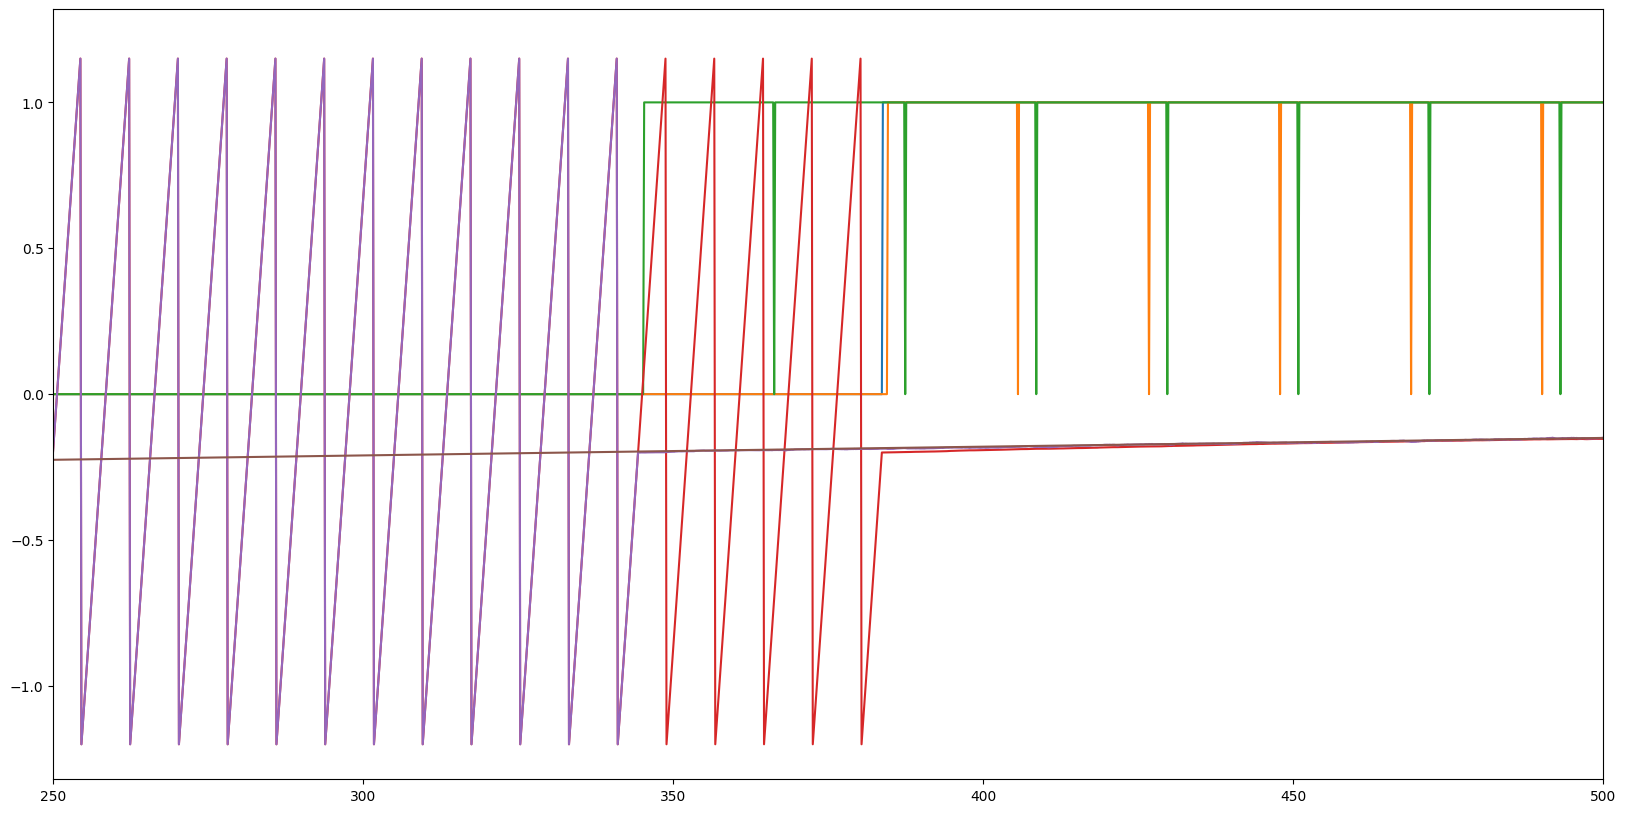

In [300]:
plt.figure(figsize=(20,10))
t = res['t']
plt.plot(t,res['detect']>0)
plt.plot(t,res['detect3'])
plt.plot(t,res2['detect3'])
plt.plot(t,res['alphadet'])
plt.plot(t,res2['alphadet'])
plt.plot(t,-res['alpha'])
plt.xlim(250,500)


#plt.xlim(0,1)

(60,) (62,)


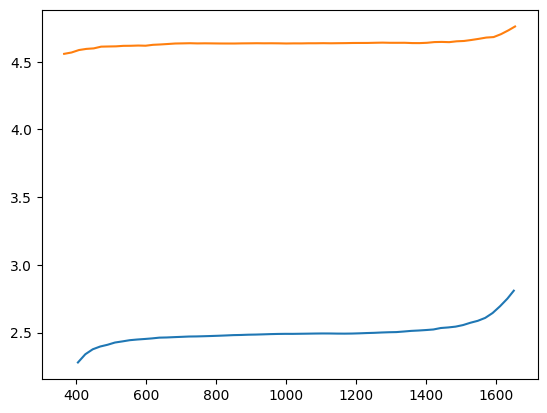

In [301]:
plt.plot(res['stage3_time'],res['stage3_offsets'])
plt.plot(res2['stage3_time'],res2['stage3_offsets'])
print (res['stage3_offsets'].shape, res2['stage3_offsets'].shape)

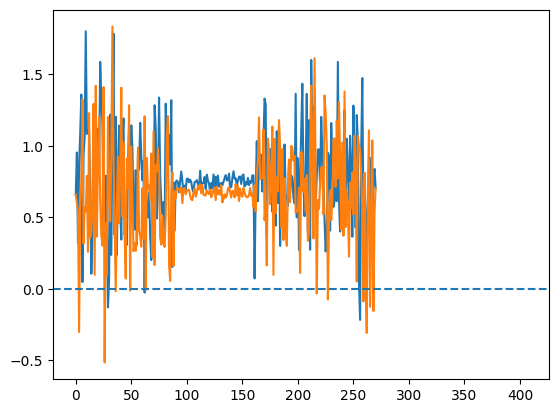

In [302]:



#plt.plot(np.angle(measured_resp))
plt.plot(np.real(res['stage3_phased'][1]))
plt.plot(np.real(res2['stage3_phased'][2]))

#plt.plot(np.imag(res['stage3_phased'][1]))
plt.axhline(0,ls='--')
#plt.axhline(1,ls='--')
#lt.semilogy()


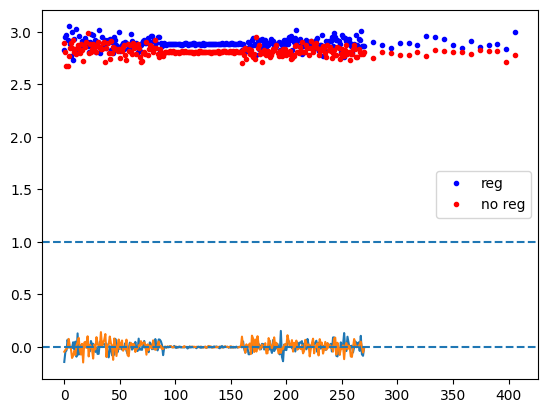

In [306]:
mean  = np.array(res['stage3_phased']).mean(axis=0)
mean2 = np.array(res2['stage3_phased']).mean(axis=0)

plt.plot(np.real(mean),'b.',label='reg')
plt.plot(np.imag(mean))
plt.plot(np.real(mean2),'r.',label='no reg')
plt.plot(np.imag(mean2))

plt.axhline(0,ls='--')
plt.axhline(1,ls='--')
plt.legend()





In [307]:
def get_snr(res):
    recon_snr = []
    for line  in res['stage3_phased']:
        w = np.where(~np.isnan(line))
        recon_snr.append(np.real(line[w]).sum()/np.imag(line[w]).std())
    return recon_snr

snr = get_snr(res)
snr2 = get_snr(res2)


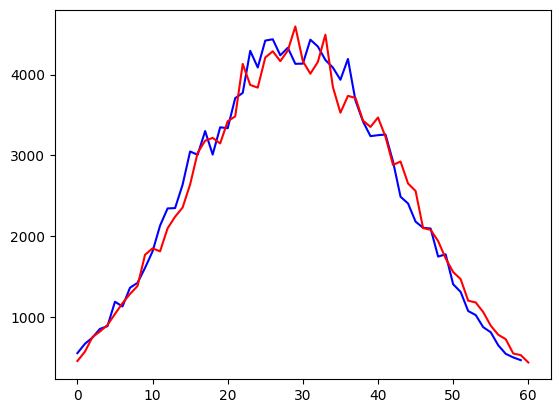

In [308]:
plt.plot(snr,'b-')
plt.plot(snr2[1:],'r-')

In [ ]:
#recon_snr2 = recon_snr+[]

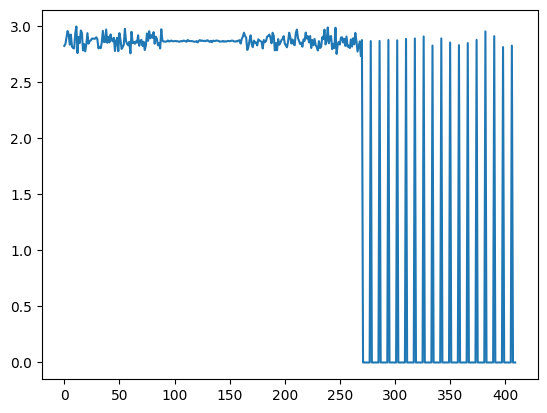

In [288]:
mean[np.isnan(mean)]=0
plt.plot(np.real(mean))

In [333]:
meanw = np.real(mean[~np.isnan(mean)])
mean2w = np.real(mean2[~np.isnan(mean2)])


In [334]:
meanw.std()/meanw.mean(),mean2w.std()/mean2w.mean()

(0.01550854384462156, 0.01539333250846823)